In [41]:
import ssl
import certifi
import requests
import numpy as np
import pandas as pd
import os
import threading
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [22]:
os.environ['SSL_CERT_FILE'] = certifi.where()

In [5]:
data_location = '/Users/paramjaswal/Desktop/Dog_Breed/Data/images'

In [6]:
_size = (224, 224)

In [7]:
def load_image(image_path, label, images, labels):
    try:
        _image = load_img(image_path, target_size=_size)
        image_array = img_to_array(_image)
        images.append(image_array)
        labels.append(label)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

def load_images(data_loc):
    images = []
    labels = []
    class_names = os.listdir(data_loc)
    class_names.sort()

    threads = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_loc, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                thread = threading.Thread(target=load_image, args=(image_path, label, images, labels))
                thread.start()
                threads.append(thread)

    for thread in threads:
        thread.join()

    return np.array(images), np.array(labels), class_names

In [8]:
images, labels, class_names = load_images(data_location)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

Loaded 20580 images from 121 classes.


In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # Split 20% of data for validation
    horizontal_flip=True,  # Apply horizontal flip
    zoom_range=0.2,  # Apply zoom
    shear_range=0.2,  # Apply shear transformation
    rotation_range=20,  # Rotate images up to 20 degrees
    brightness_range=[0.8, 1.2]  # Adjust brightness
)

train_generator = datagen.flow_from_directory(
    data_location,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Use this generator for training
)

val_generator = datagen.flow_from_directory(
    data_location,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use this generator for validation
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Training samples: 16508
Validation samples: 4072


In [10]:
def build_and_compile_model(base_model, num_classes, learning_rate=0.0001):
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
def train_and_fine_tune_model(base_model, train_generator, val_generator, num_classes, initial_epochs=10, fine_tune_epochs=10, fine_tune_layers=20):

    model = build_and_compile_model(base_model, num_classes)
    
    history = model.fit(train_generator, validation_data=val_generator, epochs=initial_epochs)
    
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history_fine_tuning = model.fit(train_generator, validation_data=val_generator, epochs=fine_tune_epochs)
    
    return model, history, history_fine_tuning


In [31]:
weights_path = 'inception_v3_weights.h5'
if not os.path.exists(weights_path):
    url = "https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
    response = requests.get(url, verify=certifi.where())
    with open(weights_path, 'wb') as f:
        f.write(response.content)

In [32]:
num_classes = len(train_generator.class_indices)

# Load the base model
base_model_inceptionv3 = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model_inceptionv3.load_weights(weights_path)

model_inceptionv3, history_inceptionv3, history_fine_tuning_inceptionv3 = train_and_fine_tune_model(base_model_inceptionv3, train_generator, val_generator, num_classes)

Epoch 1/10


/Users/paramjaswal/Desktop/Dog_Breed/VirtualEnv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 247s 471ms/step - accuracy: 0.5040 - loss: 2.3898 - val_accuracy: 0.7365 - val_loss: 0.9297
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 242s 466ms/step - accuracy: 0.7638 - loss: 0.8101 - val_accuracy: 0.7571 - val_loss: 0.8555
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 243s 468ms/step - accuracy: 0.7754 - loss: 0.7483 - val_accuracy: 0.7556 - val_loss: 0.8495
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 244s 470ms/step - accuracy: 0.7923 - loss: 0.6792 - val_accuracy: 0.7630 - val_loss: 0.8671
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 238s 458ms/step - accuracy: 0.8080 - loss: 0.6240 - val_accuracy: 0.7512 - val_loss: 0.8559
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 237s 457ms/step - accuracy: 0.8140 - loss: 0.5930 - val_accuracy: 0.7525 - val_loss: 0.9013
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 242s 467ms/step - accuracy: 0.8211 - loss: 0.5753 - val_accuracy: 0.7522 - val_loss: 0.8920
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 245s 473ms/step - accuracy: 0.8322 - loss: 0.52

In [33]:
val_loss, val_accuracy = model_inceptionv3.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

128/128 ━━━━━━━━━━━━━━━━━━━━ 47s 362ms/step - accuracy: 0.7828 - loss: 0.7234
Validation Loss: 0.7511389851570129
Validation Accuracy: 0.7802062630653381


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class index: 56
Predicted class label: n02099601-golden_retriever


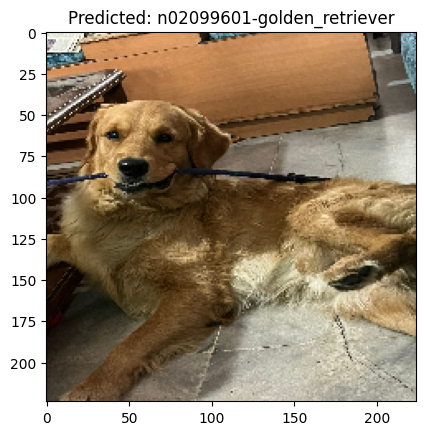

In [50]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

img_path = '/Users/paramjaswal/Desktop/Dog_Breed/luffy.jpg'
img_array = load_and_preprocess_image(img_path)

predictions = model_inceptionv3.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_label = class_labels[predicted_class_index]

print(f'Predicted class index: {predicted_class_index}')
print(f'Predicted class label: {predicted_class_label}')

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.show()